## Download Vehicle MPG Dataset

In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# fetch dataset
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes)
X = auto_mpg.data.features
y = auto_mpg.data.targets

# Combine features and target into one DataFrame for easy filtering
data = pd.concat([X, y], axis=1)

# Drop rows where the target variable is NaN
cleaned_data = data.dropna()

# Split the data back into features (X) and target (y)
X = cleaned_data.iloc[:, :-1]
y = cleaned_data.iloc[:, -1]

# Display the number of rows removed
rows_removed = len(data) - len(cleaned_data)
print(f"Rows removed: {rows_removed}")

Rows removed: 6


## Data Splitting and Standardization

In [2]:
from sklearn.model_selection import train_test_split

# Do a 70/30 split (e.g., 70% train, 30% other)
X_train, X_leftover, y_train, y_leftover = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,    # for reproducibility
    shuffle=True,       # whether to shuffle the data before splitting
)

# Split the remaining 30% into validation/testing (15%/15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_leftover, y_leftover,
    test_size=0.5,
    random_state=42,
    shuffle=True,
)

# Compute statistics for X (features)
X_mean = X_train.mean(axis=0)  # Mean of each feature
X_std = X_train.std(axis=0)    # Standard deviation of each feature

# Standardize X
X_train = ((X_train - X_mean) / X_std).to_numpy()
X_val = ((X_val - X_mean) / X_std).to_numpy()
X_test = ((X_test - X_mean) / X_std).to_numpy()

# Compute statistics for y (targets)
y_mean = y_train.mean()  # Mean of target
y_std = y_train.std()    # Standard deviation of target

# Standardize y
y_train = ((y_train - y_mean) / y_std).to_numpy().reshape(-1, 1)
y_val = ((y_val - y_mean) / y_std).to_numpy().reshape(-1, 1)
y_test = ((y_test - y_mean) / y_std).to_numpy().reshape(-1, 1)

In [3]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((274, 7), (274, 1), (59, 7), (59, 1), (59, 7), (59, 1))

Epoch 1  :::  Train Loss=0.4652439722974558  :::  Val Loss=0.34433366313768465
Epoch 2  :::  Train Loss=0.3498230335197772  :::  Val Loss=0.25763792201767427
Epoch 3  :::  Train Loss=0.25798171621365634  :::  Val Loss=0.18936677037146488
Epoch 4  :::  Train Loss=0.18803415508829957  :::  Val Loss=0.14269395541132904
Epoch 5  :::  Train Loss=0.1430327999651934  :::  Val Loss=0.11740141870037976
Epoch 6  :::  Train Loss=0.12047356979665799  :::  Val Loss=0.10601833397294447
Epoch 7  :::  Train Loss=0.11043133740431207  :::  Val Loss=0.09871156518117502
Epoch 8  :::  Train Loss=0.10417264728437861  :::  Val Loss=0.09221256324986589
Epoch 9  :::  Train Loss=0.09902563840218054  :::  Val Loss=0.08641597042243426
Epoch 10  :::  Train Loss=0.09456570378773545  :::  Val Loss=0.08137656086649615
Epoch 11  :::  Train Loss=0.09067520518743978  :::  Val Loss=0.07704081643552606
Epoch 12  :::  Train Loss=0.08726809255321599  :::  Val Loss=0.07331584799785278
Epoch 13  :::  Train Loss=0.084270329623

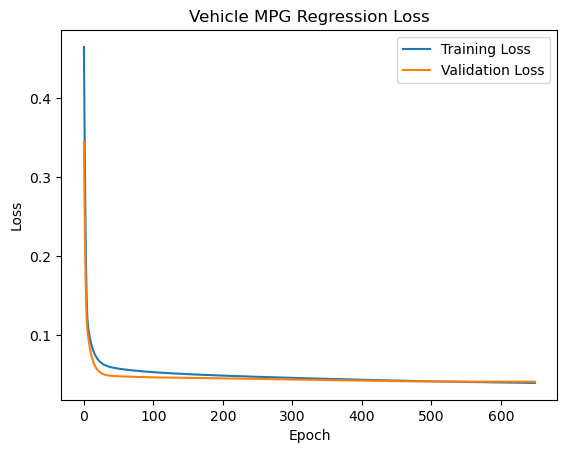

In [4]:
from MLP import MultilayerPerceptron, Layer, Relu, SquaredError, Linear, Mish, Tanh, Sigmoid, Softplus
import matplotlib.pyplot as plt

mlp = MultilayerPerceptron([
    Layer(fan_in=X_train.shape[1], fan_out=64, activation_function=Mish(), dropout_rate=0),
    Layer(fan_in=64, fan_out=32, activation_function= Mish(), dropout_rate=0),
    Layer(fan_in=32, fan_out=16, activation_function=Mish(), dropout_rate=0),
    Layer(fan_in=16,fan_out=1, activation_function= Linear(), dropout_rate=0),
])

# Train the model using RMSProp.
training_losses, validation_losses = mlp.train(
    train_x=X_train,
    train_y=y_train, 
    val_x=X_val,
    val_y=y_val,     
    loss_func=SquaredError(),
    learning_rate=1E-4,
    batch_size=8,
    epochs=650,
    use_rmsprop=True,
    decay_rate=0.9,
    epsilon=1e-8
)

# Plot training and validation losses.
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Vehicle MPG Regression Loss")
plt.legend()
plt.show()


Total Testing Loss: 0.04914814902723082


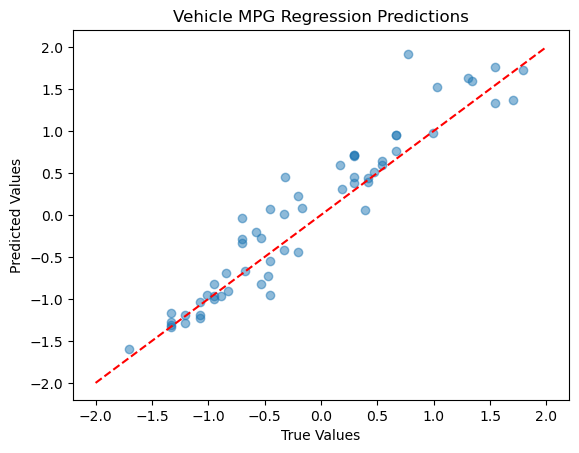

Evaluation Metrics:
Mean Squared Error (MSE): 0.0983
Mean Absolute Error (MAE): 0.2291



In [5]:
import random
import numpy as np

y_test_pred = mlp.forward(X_test, training=False)

test_loss = SquaredError().loss(y_test, y_test_pred)
print(f"Total Testing Loss: {test_loss}")

# Plot the predicted vs. true values.
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([-2, 2], [-2, 2], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Vehicle MPG Regression Predictions")
plt.show()

mse = np.mean((y_test_pred - y_test) ** 2) 
# Calculate Mean Absolute Error (MAE) 
mae = np.mean(np.abs(y_test_pred - y_test))
print("Evaluation Metrics:") 
print(f"Mean Squared Error (MSE): {mse:.4f}") 
print(f"Mean Absolute Error (MAE): {mae:.4f}\n")


In [13]:
indices = random.sample(range(X_test.shape[0]), 10)
# Get the corresponding test inputs and actual outputs
X_sample = X_test[indices]
mpg_actual = y_test[indices] * y_std + y_mean
mpg_pred = mlp.forward(X_sample) * y_std + y_mean
print("Sample\tPredicted MPG\tActual MPG")
for i, idx in enumerate(indices):
    print(f"{idx}\t{mpg_pred[i,0]:.2f}\t\t{mpg_actual[i,0]:.2f}")
# mlp.forward(X_test[:10], training=False)* y_std + y_mean, y_test[:10] * y_std + y_mean

Sample	Predicted MPG	Actual MPG
25	18.08		16.90
57	23.74		21.00
1	17.03		16.00
10	27.74		27.40
56	26.65		26.00
49	31.24		29.00
30	26.10		25.10
36	24.09		26.80
50	37.45		38.00
39	31.49		31.60
